# Lab 7 - Homography and Image Matching

The goal of this lab is to get a sense of how we can use (i) feature detection, (ii) feature matching, and (iii) image warping (e.g., a homography) to align two images of the same scene taken from two separate viewpoints. The starter code below does the following:

- Imports necessary libraries 
- Loads images and converts to grayscale
- Defines functions and parameters to perform ransac and generate a homography from one image to the next

## Your task

Your first task today is to first align and visualize the two images after applying the homography to align them. Use the function kornia.geometry.warp_perspective(image, transform, output_size) to perform the warping. Then stitch the images together and plot them using matplotlib (note, you will have to write the code to combine them!). 

The second task is to do the same thing (i.e., reusing the sample code given, calculate the transformation and align the images, then visualize) with two images you have taken with your own cell phone camera. Then you are done the lab :-)

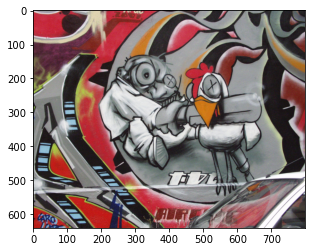

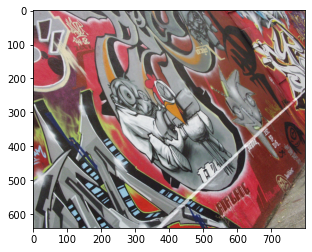

In [24]:
#First load libraries and images
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import numpy as np
import kornia
import cv2
from kornia.feature import *
from kornia.geometry import *
from time import time
import torch.optim as optim
from torch.nn import Parameter
from kornia.color import rgb_to_grayscale
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" #Prevents an unusual error where displaying images will crash the kernel?


img1 = Image.open('graffiti.png')
img2 = Image.open('graffiti2.png')

timg1 = kornia.utils.image_to_tensor(np.array(img1), False).float() / 255.
timg2 = kornia.utils.image_to_tensor(np.array(img2), False).float() / 255.

timg = torch.cat([timg1,timg2], dim=0)

timg_gray = kornia.color.rgb_to_grayscale(timg)

plt.imshow(kornia.utils.tensor_to_image(timg[0]))
plt.figure()
plt.imshow(kornia.utils.tensor_to_image(timg[1]))


In [25]:
# Define function for local feature matching

def visualize_LAF(img, LAF, img_idx = 0):
    x, y = kornia.feature.laf.get_laf_pts_to_draw(LAF, img_idx)
    plt.figure()
    plt.imshow(kornia.utils.tensor_to_image(img[img_idx]))
    plt.plot(x, y, 'r')
    plt.show()
    return

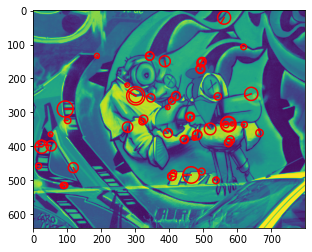

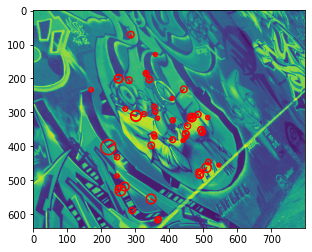

56 inliers


In [26]:
#Now lets define local deature detector and descriptor

device = torch.device('cpu')
# device = torch.device('cuda:0')

# define number of patches
PS = 41

# set up sift parameters and detector module
sift = kornia.feature.SIFTDescriptor(PS, rootsift=True).to(device)
descriptor = sift
resp = BlobHessian()
scale_pyr = kornia.geometry.ScalePyramid(3, 1.6, PS, double_image=True)
nms = kornia.geometry.ConvQuadInterp3d(10)
n_features = 4000
detector = ScaleSpaceDetector(n_features,
                              resp_module=resp,
                              nms_module=nms,
                              scale_pyr_module=scale_pyr,
                              ori_module=kornia.feature.LAFOrienter(19),
                              mr_size=6.0).to(device)

# get local affine features
with torch.no_grad():
    lafs, resps = detector(timg_gray)
    patches =  kornia.feature.extract_patches_from_pyramid(timg_gray, lafs, PS)
    B, N, CH, H, W = patches.size()
    # Descriptor accepts standard tensor [B, CH, H, W], while patches are [B, N, CH, H, W] shape
    # So we need to reshape a bit :) 
    descs = descriptor(patches.view(B * N, CH, H, W)).view(B, N, -1)
    scores, matches = kornia.feature.match_snn(descs[0], descs[1], 0.9)

# Now fine a homography between the two sets of points based on RANSAV
src_pts = lafs[0,matches[:,0], :, 2].data.cpu().numpy()
dst_pts = lafs[1,matches[:,1], :, 2].data.cpu().numpy()


# calculate homography and select inliers
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 1.0, 0.999, 10000)
inliers = matches[torch.from_numpy(mask).bool().squeeze(), :]

for i in range(2):
    visualize_LAF(timg_gray, lafs[:,inliers[:,i]], i)
print (len(inliers), 'inliers')

In [27]:
# 1) perform warping on image and visualize overlapping pair

In [28]:
timg_gray.shape

torch.Size([2, 1, 640, 800])

In [29]:
timg_gray[0].shape

torch.Size([1, 640, 800])

In [30]:
#Displays Tensors as image
def imshowTorch(input):
    image = kornia.tensor_to_image(input) #Converts to HWC format
    plt.imshow(image) #As matplotlib requires arrays 

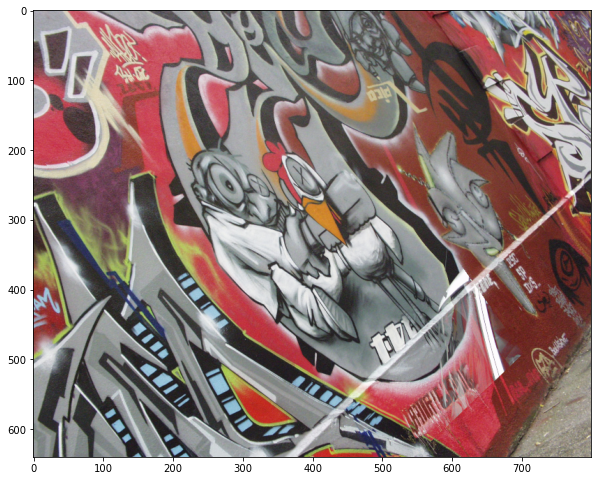

In [31]:
k = torch.tensor(H, dtype = torch.float)
k = k.unsqueeze(0)
(h,w) = [640,800]
out = kornia.geometry.warp_perspective(timg1,k,(h,w))
maximum = torch.max(out,timg2)
plt.figure(figsize=(10,10))
imshowTorch(maximum)


In [ ]:
# 2) Find the homography, align, and visualize your own two images

print(torch.__version__)